# LSTM_Attention实现中文商品评论二分类

In [9]:
import os
import csv
import time
import datetime
import random
import json
from collections import Counter
from math import sqrt
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend
from tensorflow.keras.layers import BatchNormalization,Layer,Input,Conv2D,MaxPool2D,concatenate,Flatten,Dense,Dropout,Embedding,Reshape,LSTM
from tensorflow.keras import Sequential,optimizers,losses
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import initializers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from bs4 import BeautifulSoup
import logging
import gensim
from gensim.models import word2vec

import multiprocessing
import yaml
import jieba

# 参数配置

In [2]:
class Config(object):
    
    #数据集路径
    dataSource = "../data/goods_zh.txt"
    stopWordSource = "../data/stopword.txt"
    
    #分词后保留大于等于最低词频的词
    miniFreq=1
    
    
    #统一输入文本序列的定长，取了所有序列长度的均值。超出将被截断，不足则补0
    sequenceLength = 200  
    batchSize=64
    epochs=10
    
    numClasses = 2
    #训练集的比例
    rate = 0.8  
    
    
    #生成嵌入词向量的维度
    embeddingSize = 150
    
    #卷积核数
    numFilters = 30
    
    #卷积核大小
    filterSizes = [2,3,4,5]
    dropoutKeepProb = 0.5
    
    #L2正则系数
    l2RegLambda = 0.1
    
   
    
# 实例化配置参数对象
config = Config()

In [13]:
config.batchSize

128

# 预训练词向量

In [17]:
# 设置输出日志
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

file = open("../data/goods_zh.txt") 
sentences=[]
for line in file:
    temp=line.replace('\n','').split(',,')
    sentences.append(jieba.lcut(temp[0]))
file.close()


model = word2vec.Word2Vec(sentences,size=110,
                     min_count=1,
                     window=10,
                     workers=multiprocessing.cpu_count(),sg=1,
                     iter=20)
model.save('../data/word2VecModel')


W0507 10:48:44.101238 140735550804864 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance


In [18]:
model = gensim.models.Word2Vec.load('../data/word2VecModel')
model.wv.vocab.keys() 

dict_keys(['才', '用', '就', '发现', '相机', '打开', '迟钝', '，', '半天', '反应', '不', '过来', '有时候', '还会卡', '出去', '他们', '又', '给', '解决方案', '。', '还', '没', '穿', '二天', '起毛', '了', '坑', '呢', '！', '能教', '我', '怎样', '将', '双卡', '和', '内存卡', '一起', '装进去', '吗', '？', '如果', '不能', '说', '什么', '支持', 'SD', '?', '-', '诺基亚', '手机', '做工', '质量', '太', '差', '后壳', '垃圾', '没用', '几天', '掉', '漆', '为', '毛要', '金属', '材质', '为啥', '不用', '陶瓷', '呀', '我后', '壳', '贴膜', '漆该', '完', '整体', '的', '感觉', '还是', '不错', '非常', '满意', '京东', '售后服务', '买', '之前', '联系', '客服', '由于', '公司', '新开', '增值税', '发票', '开票', '信息', '出来', '要', '缓缓', '再', '结果', '一声不吭', '开', '电子', '换', '电脑', '发报', '帐', '裤子', '很', '好', '昨天', '刚买', '保修', '到', '9', '月份', '还有', '一次', '鉴定', '这', '是', '啥', '机子', '冬天', '比较', '保暖', '品质', '保证', '价格', '实惠', '收到', '后', '知道', '怎么', '吧', '从', '下单', '心情', '兴奋', '之后', '糟糕', '透', '东西', '都', '没有', '一部', '一个', '充电器', '连', '百元', '机', '标配', '耳机', '别的', '计较', '太过分', '啊', ' ', '在', '北京', '呆', '3', '天', '动弹', '真', '几把', '慢', '好大', '味道', '放', '三四天', '那个', '味', '去', '不了',

In [21]:
model['兢兢业业']

/Users/monstar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.46147937e-01,  6.88549355e-02, -5.21679483e-02, -2.48637825e-01,
        2.34183157e-03,  2.65145265e-02,  1.15543101e-02, -1.35425525e-02,
       -3.03508565e-02,  3.94282266e-02, -4.63725105e-02,  1.12336710e-01,
       -1.94088817e-01, -6.53039142e-02, -8.10260922e-02,  1.73059776e-01,
       -9.62141156e-02, -1.07682943e-01, -1.17582262e-01,  1.21479267e-02,
        1.19785182e-01, -1.68108523e-01, -1.18932672e-01,  7.38137811e-02,
       -2.89786160e-01,  6.71456009e-02, -1.83266014e-01, -7.93667685e-04,
       -3.62327784e-01, -1.40947908e-01, -8.42110962e-02, -1.07920848e-01,
       -1.44627586e-01,  1.01627246e-01, -7.43076624e-03,  1.54120056e-02,
       -2.18680888e-01,  7.73432851e-02, -7.19477236e-02, -2.64227450e-01,
       -3.00898314e-01,  1.83396459e-01, -1.90125331e-01,  2.15625092e-01,
        2.32338607e-02, -9.85607579e-02,  3.56265694e-01,  5.62353618e-02,
       -1.90471932e-01, -2.53070205e-01, -4.26846087e-01,  2.07112938e-01,
       -7.37276748e-02, -

# 数据预处理

In [4]:
# 数据预处理的类，生成训练集和测试集
class Dataset(object):
    def __init__(self, config):
        self.dataSource = config.dataSource
        self.stopWordSource = config.stopWordSource  
        
        # 每条输入的序列处理为定长
        self.sequenceLength = config.sequenceLength  
        
        self.embeddingSize = config.embeddingSize
        self.batchSize = config.batchSize
        self.rate = config.rate
        self.miniFreq=config.miniFreq
        
        self.stopWordDict = {}
        
        self.trainReviews = []
        self.trainLabels = []
        
        self.evalReviews = []
        self.evalLabels = []
        
        self.wordEmbedding =None
        self.n_symbols=0
        
        self.wordToIndex = {}
        self.indexToWord = {}
        
        
        
    def readData(self, filePath):
        file = open(filePath) 
        text=[]
        label=[]
        for line in file:
            temp=line.replace('\n','').split(',,')
            text.append(temp[0])
            label.append(temp[1])
        file.close()
        
        print('data:',len(text),len(label))
        texts = [jieba.lcut(document.replace('\n', '')) for document in text]

        return texts, label

    
    def readStopWord(self, stopWordPath):
        """
        读取停用词
        """
        
        with open(stopWordPath, "r") as f:
            stopWords = f.read()
            stopWordList = stopWords.splitlines()
            # 将停用词用列表的形式生成，之后查找停用词时会比较快
            self.stopWordDict = dict(zip(stopWordList, list(range(len(stopWordList)))))
    
    
    def getWordEmbedding(self, words):
        """
        按照我们的数据集中的单词取出预训练好的word2vec中的词向量
        """
        
        #中文
        model = gensim.models.Word2Vec.load('../data/word2VecModel')
        
        vocab = []
        wordEmbedding = []
        
        # 添加 "pad" 和 "UNK", 
        vocab.append("pad")
        wordEmbedding.append(np.zeros(self.embeddingSize))
        
        vocab.append("UNK")
        wordEmbedding.append(np.random.randn(self.embeddingSize))
        
        for word in words:
            try:
                
                #中文
                vector =model[word]
                
                vocab.append(word)
                wordEmbedding.append(vector)
            except:
                
                print(word + " : 不存在于词向量中")
                
        return vocab, np.array(wordEmbedding)
    
    
    
    def genVocabulary(self, reviews):
        """
        生成词向量和词汇-索引映射字典，可以用全数据集
        """
        
        allWords = [word for review in reviews for word in review]
        
        # 去掉停用词
        subWords = [word for word in allWords if word not in self.stopWordDict]
        
        wordCount = Counter(subWords)  # 统计词频，排序
        sortWordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
        
        # 去除低频词
        words = [item[0] for item in sortWordCount if item[1] >= self.miniFreq ]
        
        
        #获取词列表和顺序对应的预训练权重矩阵
        vocab, wordEmbedding = self.getWordEmbedding(words)
        
        self.wordEmbedding = wordEmbedding
        
        self.wordToIndex = dict(zip(vocab, list(range(len(vocab)))))
        self.indexToWord = dict(zip(list(range(len(vocab))), vocab))
        self.n_symbols = len(self.wordToIndex) + 1
        
        # 将词汇-索引映射表保存为json数据，之后做inference时直接加载来处理数据
        with open("../data/wordJson/wordToIndex.json", "w", encoding="utf-8") as f:
            json.dump(self.wordToIndex, f)
        
        with open("../data/wordJson/indexToWord.json", "w", encoding="utf-8") as f:
            json.dump(self.indexToWord, f)
            
            
            
            
    
    def reviewProcess(self, review, sequenceLength, wordToIndex):
        """
        将数据集中的每条评论里面的词，根据词表，映射为index表示
        每条评论 用index组成的定长数组来表示
        
        """
        
        reviewVec = np.zeros((sequenceLength))
        sequenceLen = sequenceLength
        
        # 判断当前的序列是否小于定义的固定序列长度
        if len(review) < sequenceLength:
            sequenceLen = len(review)
            
        for i in range(sequenceLen):
            if review[i] in wordToIndex:
                reviewVec[i] = wordToIndex[review[i]]
            else:
                reviewVec[i] = wordToIndex["UNK"]

        return reviewVec

    
    
    
    def genTrainEvalData(self, x, y, rate):
        """
        生成训练集和验证集
        """
        
        reviews = []
        labels = []
        
        # 遍历所有的文本，将文本中的词转换成index表示
        for i in range(len(x)):
            
            reviewVec = self.reviewProcess(x[i], self.sequenceLength, self.wordToIndex)
            reviews.append(reviewVec)
            
            labels.append([y[i]])
            
        trainIndex = int(len(x) * rate)
        
       
        #trainReviews = sequence.pad_sequences(reviews[:trainIndex], maxlen=self.sequenceLength)
        trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
        trainLabels = np.array(labels[:trainIndex], dtype="float32")
        trainLabels = to_categorical(trainLabels,num_classes=2) 
        
        #evalReviews = sequence.pad_sequences(reviews[trainIndex:], maxlen=self.sequenceLength)
        evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")
        evalLabels = np.array(labels[trainIndex:], dtype="float32")
        evalLabels = to_categorical(evalLabels,num_classes=2) 

        return trainReviews, trainLabels, evalReviews, evalLabels
        
        
        
 
            
    def dataGen(self):
        """
        初始化训练集和验证集
        """
        
        #读取停用词
        self.readStopWord(self.stopWordSource)
        
        #读取数据集
        reviews, labels = self.readData(self.dataSource)
        
        #分词、去停用词
        #生成 词汇-索引 映射表和预训练权重矩阵，并保存
        self.genVocabulary(reviews)
        
        
        #初始化训练集和测试集
        trainReviews, trainLabels, evalReviews, evalLabels = self.genTrainEvalData(reviews, labels, self.rate)
        self.trainReviews = trainReviews
        self.trainLabels = trainLabels
        
        self.evalReviews = evalReviews
        self.evalLabels = evalLabels
        
        
data = Dataset(config)
data.dataGen()

Building prefix dict from the default dictionary ...
I0509 13:01:12.681818 140736014676864 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/60/2w7_vlcs36d59_tzgd2g3hv40000gn/T/jieba.cache
I0509 13:01:12.684075 140736014676864 __init__.py:131] Loading model from cache /var/folders/60/2w7_vlcs36d59_tzgd2g3hv40000gn/T/jieba.cache


data: 101058 101058


Loading model cost 1.172 seconds.
I0509 13:01:13.856347 140736014676864 __init__.py:163] Loading model cost 1.172 seconds.
Prefix dict has been built succesfully.
I0509 13:01:13.857898 140736014676864 __init__.py:164] Prefix dict has been built succesfully.
/Users/monstar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [5]:
print("train data shape: {}".format(data.trainReviews.shape))
print("train label shape: {}".format(data.trainLabels.shape))
print("eval data shape: {}".format(data.evalReviews.shape))

train data shape: (80846, 200)
train label shape: (80846, 2)
eval data shape: (20212, 200)


# 定义网络结构

In [20]:

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(** kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, seq_len)
        x = backend.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        a = backend.softmax(backend.tanh(backend.dot(x, self.W) + self.b))
        outputs = backend.permute_dimensions(a * x, (0, 2, 1))
        outputs = backend.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]



def train_lstm(n_symbols,embedding_weights,config):
    
    model =Sequential([
        Embedding(input_dim=n_symbols, output_dim=config.embeddingSize,
                        weights=[embedding_weights],
                        input_length=config.sequenceLength),
        
    #LSTM层
    Dropout(config.dropoutKeepProb),
    LSTM(50,activation='tanh', dropout=0.5, recurrent_dropout=0.5,return_sequences=True),
    LSTM(50, dropout=0.5, recurrent_dropout=0.5,return_sequences=True),
    LSTM(50,return_sequences=True),
    
    #BatchNormalization(),
    AttentionLayer(),
    Dropout(config.dropoutKeepProb),
    Dense(2, activation='softmax')])
  
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model
    
    
    
wordEmbedding = data.wordEmbedding
n_symbols=data.n_symbols
model = train_lstm(n_symbols,wordEmbedding,config)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 150)          6684450   
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 150)          0         
_________________________________________________________________
unified_lstm_21 (UnifiedLSTM (None, 200, 50)           40200     
_________________________________________________________________
unified_lstm_22 (UnifiedLSTM (None, 200, 50)           20200     
_________________________________________________________________
unified_lstm_23 (UnifiedLSTM (None, 200, 50)           20200     
_________________________________________________________________
attention_layer_6 (Attention (None, 50)                40200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)               

# 训练模型

In [21]:
x_train = data.trainReviews
y_train = data.trainLabels
x_eval = data.evalReviews
y_eval = data.evalLabels

wordEmbedding = data.wordEmbedding
n_symbols=data.n_symbols


reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('./stack_lstm_model/best_model/model_{epoch:02d}-{val_accuracy:.2f}.hdf5', save_best_only=True, save_weights_only=True)
history = model.fit(x_train, y_train, batch_size=config.batchSize, epochs=config.epochs, validation_split=0.3,shuffle=True, callbacks=[reduce_lr,early_stopping,model_checkpoint])
#验证

scores = model.evaluate(x_eval, y_eval)

#保存模型
yaml_string = model.to_yaml()
with open('./stack_lstm_model/stack_lstm.yml', 'w') as outfile:
    outfile.write( yaml.dump(yaml_string, default_flow_style=True) )
model.save_weights('./stack_lstm_model/stack_lstm.h5')

print('test_loss: %f, accuracy: %f' % (scores[0], scores[1]))

Train on 56592 samples, validate on 24254 samples
Epoch 1/10
56592/56592 [==============================] - 2822s 50ms/sample - loss: 0.3420 - accuracy: 0.8538 - val_loss: 0.2015 - val_accuracy: 0.9244
Epoch 2/10
56592/56592 [==============================] - 2244s 40ms/sample - loss: 0.1981 - accuracy: 0.9307 - val_loss: 0.1861 - val_accuracy: 0.9318
Epoch 3/10
56592/56592 [==============================] - 2184s 39ms/sample - loss: 0.1662 - accuracy: 0.9426 - val_loss: 0.1796 - val_accuracy: 0.9349
Epoch 4/10
56592/56592 [==============================] - 2202s 39ms/sample - loss: 0.1471 - accuracy: 0.9498 - val_loss: 0.1812 - val_accuracy: 0.9349
Epoch 5/10
56592/56592 [==============================] - 2176s 38ms/sample - loss: 0.1367 - accuracy: 0.9543 - val_loss: 0.1855 - val_accuracy: 0.9349
Epoch 6/10
56592/56592 [==============================] - 1819s 32ms/sample - loss: 0.1277 - accuracy: 0.9569 - val_loss: 0.1962 - val_accuracy: 0.9334
Epoch 7/10
56592/56592 [==============

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

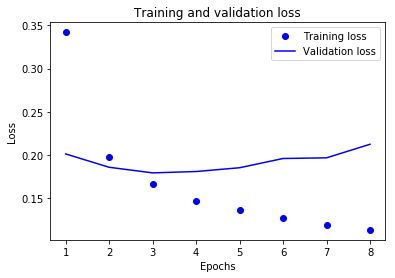

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

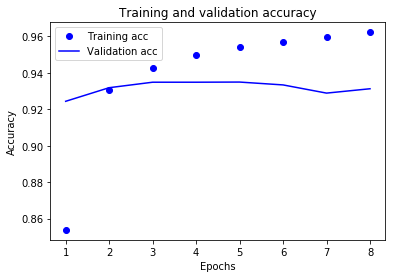

In [24]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()